In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from scipy import stats as sc
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
import pickle

Using TensorFlow backend.


In [2]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    
def rfFeaturePlot(rf_reg, col_list, plot=True, title="Feature importances"):
    importances = rf_reg.feature_importances_

    std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    if plot:
        # Plot the feature importances of the forest
        plt.figure(1,(12,9))
        plt.title(title)
        plt.bar(range(rf_reg.n_features_), importances[indices],  
               color="r", align="center")
        plt.xticks(range(rf_reg.n_features_),col_list[indices], rotation='vertical', fontsize=15)
#         plt.xlim([-1,rf_reg.n_features_)
        plt.xlim([-1, 20.5])
        plt.show()
        
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]

def plotPca(pca, Xtrain):
    plt.figure(1,(8,6))
    plt.bar(range(1, Xtrain.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, Xtrain.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xlim([0, 50])
    plt.show()
    
def get_important_features(transformed_features, components_, columns):
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

In [3]:
complete_season_path = "master_data_ver2/all_season_master_data.csv"
complete_season_df = pd.read_csv(complete_season_path)

In [4]:
complete_season_df

,match_id,date,home_team_name,away_team_name,winner,home_goal,away_goal,goal_difference,home_team_team_rating,home_team_att_goal_low_left,...,away_player_11_six_yard_block,away_player_11_post_scoring_att,away_player_11_att_pen_target,away_player_11_penalty_save,away_player_11_penalty_conceded,away_player_11_clearance_off_line,away_player_11_att_pen_goal,away_player_11_att_pen_miss,away_player_11_own_goals,away_player_11_att_pen_post
0,829513,16/08/2014 17:30:00,Arsenal,Crystal Palace,1,2,1,1,7.015000,1.000000,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829514,18/08/2014 20:00:00,Burnley,Chelsea,-1,1,3,-2,6.298571,1.000000,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,829515,16/08/2014 15:00:00,Leicester,Everton,0,2,2,0,6.714286,1.454545,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,829516,17/08/2014 13:30:00,Liverpool,Southampton,1,2,1,1,7.280769,1.000000,...,0.00000,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,829517,16/08/2014 12:45:00,Manchester United,Swansea,-1,1,2,-1,6.707143,1.000000,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,829518,17/08/2014 16:00:00,Newcastle United,Manchester City,-1,0,2,-2,6.471429,1.272727,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,829519,16/08/2014 15:00:00,Queens Park Rangers,Hull,-1,0,1,-1,6.715000,1.333333,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,829520,16/08/2014 15:00:00,Stoke,Aston Villa,-1,0,1,-1,6.799231,1.083333,...,1.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,829521,16/08/2014 15:00:00,West Bromwich Albion,Sunderland,0,2,2,0,6.548571,1.000000,...,0.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,829522,16/08/2014 15:00:00,West Ham,Tottenham,-1,0,1,-1,6.659286,1.076923,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_df = complete_season_df.drop(columns=['match_id', 'date', 'home_team_name', 'away_team_name'])
X_unp = data_df.iloc[:,4:]
y = data_df.iloc[:,0]

In [7]:
X_unp.shape, y.shape

((1520, 938), (1520,))

# Data Preprocess

In [14]:
X_v = variance_threshold_selector(X_unp, 0.7)
X_v.shape

(1520, 339)

In [22]:
X = kBestSelector(X_v, y, score_func = chi2, k = 100)

In [23]:
X.columns

Index(['home_team_accurate_pass', 'home_team_total_pass',
       'home_team_ontarget_scoring_att', 'home_player_1_fpl_minutes',
       'home_player_1_fpl_points', 'home_player_2_fpl_points',
       'home_player_3_fpl_minutes', 'home_player_3_fpl_points',
       'home_player_3_accurate_pass', 'home_player_4_fpl_minutes',
       'home_player_4_fpl_points', 'home_player_4_total_pass',
       'home_player_4_accurate_pass', 'home_player_5_fpl_points',
       'home_player_6_fpl_minutes', 'home_player_6_fpl_points',
       'home_player_6_fpl_bonus', 'home_player_6_touches',
       'home_player_6_total_pass', 'home_player_6_accurate_pass',
       'home_player_7_fpl_minutes', 'home_player_7_fpl_goals',
       'home_player_7_fpl_points', 'home_player_7_fpl_bonus',
       'home_player_7_touches', 'home_player_7_total_pass',
       'home_player_7_accurate_pass', 'home_player_8_fpl_minutes',
       'home_player_8_fpl_points', 'home_player_8_touches',
       'home_player_8_total_pass', 'home_player_

# Data splitting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)

In [25]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train.values)
X_test_std = stdsc.transform(X_test.values)

In [26]:
rbsc = RobustScaler()
X_train_rbs = rbsc.fit_transform(X_train.values)
X_test_rbs = rbsc.transform(X_test.values)

In [27]:
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train.values)
X_test_mm = mm.transform(X_test.values)

In [28]:
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train_mm)
# X_test = pca.transform(X_test_mm)
# plotPca(pca, X_train)

# Modeling

In [29]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


CV SCORES: [0.52777778 0.57638889 0.55555556 0.53846154 0.52816901 0.56737589
 0.58156028 0.53900709]
TRAINING Accuracy: 0.623
Average 8-Fold Training CV Score: 0.5517870046474519
TEST Accuracy: 0.584


In [21]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


CV SCORES: [0.52083333 0.52777778 0.48611111 0.54545455 0.52112676 0.5248227
 0.53191489 0.5106383 ]
TRAINING Accuracy: 0.539
Average 8-Fold Training CV Score: 0.5210849268456212
TEST Accuracy: 0.489


In [30]:
log_reg = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(log_reg, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_rbs, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test_rbs, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.58078603 0.59825328 0.55458515 0.59030837 0.55309735]
TRAINING Accuracy: 0.642
Average 5-Fold Training CV Score: 0.5754060338650536
TEST Accuracy: 0.566


In [31]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train_std, y_train)
cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_std, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test_std, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.47598253 0.46724891 0.49781659 0.52422907 0.48672566]
TRAINING Accuracy: 0.508
Average 5-Fold Training CV Score: 0.49040055470823596
TEST Accuracy: 0.479


In [32]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
rfc.fit(X_train, y_train)
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test, y_test))

CV SCORES: [0.56331878 0.56768559 0.50655022 0.54185022 0.55752212]
Average 5-Fold Training CV Score: 0.5473853858621922
Accuracy: 0.547


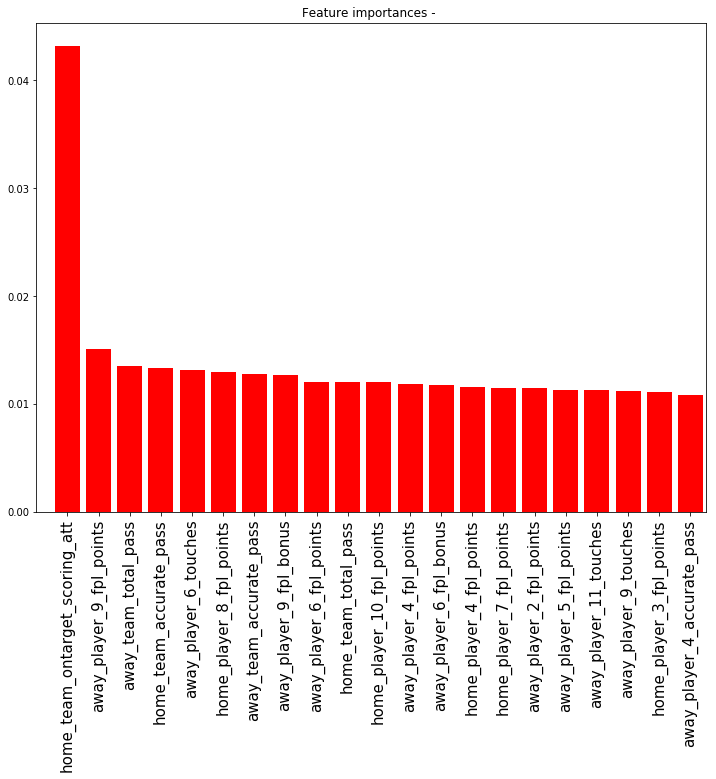

In [33]:
rfFeaturePlot(rfc, X.columns, title="Feature importances - ")

In [34]:
model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.43231441 0.45851528 0.41921397 0.46696035 0.44247788]
Average 5-Fold Training CV Score: 0.44389637933027454
Accuracy: 0.376


In [35]:
model = GaussianNB()
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.45851528 0.53275109 0.44104803 0.51982379 0.45575221]
Average 5-Fold Training CV Score: 0.4815780822831971
Accuracy: 0.487


In [36]:
model = SVC(C=0.5, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.51965066 0.58078603 0.49781659 0.55947137 0.52654867]
Average 5-Fold Training CV Score: 0.5368546626628617
Accuracy: 0.547


In [ ]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

[LibSVM]

c:\users\deni susanto\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=50000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
model = SVC(C=0.5, kernel = 'rbf', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

In [ ]:
model = SVC(C=0.06, kernel = 'sigmoid', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

In [ ]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(model, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_rbs, y_test))

In [ ]:
model = SVC(C=0.08, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))

In [ ]:
model = GradientBoostingClassifier(learning_rate = 0.05, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

In [ ]:
model = GradientBoostingClassifier(learning_rate = 0.005, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))